# NLP Transformers

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

Using multi-head attention from [Attention is All You Need](https://arxiv.org/abs/1706.03762), we can create attention only architecture called **transformer**. The key benefit of a transformer architecture is scalability via parallelism; the matrix operation in each head can run independent of other heads. 

![Transformer](assets/transformer.png)

There are 2 phases, encoding and decoding.

## Encoding

We obtain the embeddings $X$ for an input sequence, using the same example from Andrew Ng's lecture i.e. "Jane viste l'Afrique en septembre". 

$X$, in conjunction with $Q$, $K$, and $V$, is used to compute the output of the heads. The output will be concatenated, summed with residuals, and normalized. The normalized outputs will then be fed into a non-linear unit such as a simple feedfoward neural network. The output of the neural network will be summed with residuals and normalized again. The encoder block will be stacked `N` times e.g. `N=6`. Each output should have the same shape as $Q$, $K$, $V$ just like the inputs to each block. 

<img src="assets/encoder.png" alt="Encoder" width="400"/>


In [2]:
def clones(module, N):
    """Produce N identical modules
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class LayerNorm(nn.Module):
    """Provides normalization for a layer output
    """
    def __init__(self, features, eps=1e-6):
        super().__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps
        
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

    
class SublayerConnection(nn.Module):
    """Provides residual connection followed by a layer norm.
    """
    def __init__(self, size, dropout):
        super().__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))
    

class EncoderLayer(nn.Module):
    """Encoder layer is made up of self attention and feed forward
    """
    def __init__(self, size, self_attn, feed_forward, dropout):
        super().__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size
        
    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_foward)
    
    
class Encoder(nn.Module):
    """Encoder is made up of N encoder layer"""
    def __init__(self, layer, N):
        super(self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        """Forward pass inputs and mask through every layer
        """
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

## Decoding

First the `SOS` start of sentence token is fed into the decoder generate the query matrix $Q$ while discarding the $K$ and $V$ matrix. The decoded sequence is always the "query" while the keys and values should be found in the encoded sequences. The decoding attention blocks will run `N` times just like the encoding attention blocks. 

<img src="assets/decoder.png" alt="Encoder" width="600"/>

The feed-forward network in the decoder should generate the next word in the seqeuence, i.e. `Jane` ideally. Then `SOS` and `Jane` are fed into the decoder blocks again and repeat the same logic until the `EOS` is reached.

In [3]:
class DecoderLayer(nn.Module):
    """Decoder layer is made of self attention, source attention from the encoder, and feed forward
    """
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)
    
class Decoder(nn.Module):
    """Decoder is made up of N decoder layers with masking.
    """
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

## Subsequent Masking

> We also modify the self-attention sub-layer in the decoder stack to prevent positions from attending to 
  subsequent positions. This masking, combined with fact that the output embeddings are offset by one position, 
  ensures that the predictions for position i can depend only on the known outputs at positions less than i.

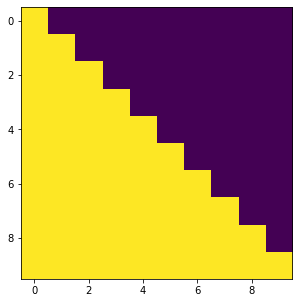

In [4]:
def subsequent_mask(size):
    """Mask out subsequent positions.
    """
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0


plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(10)[0])

## Attention

![Multi-head Attention](assets/multi-head.png)

In [5]:
def attention(query, key, value, mask=None, dropout=None):
    """Compute scaled dot product attention
    """
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn


class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        """Create multi-head attention by taking in model dimension and number of heads.
        """
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = [
            l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
            for l, x in zip(self.linears, (query, key, value))
        ]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) Concat using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

## Position-wise Feed-forward Networks

> In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully connected 
  feed-forward network, which is applied to each position separately and identically. This consists of two linear 
  transformations with a ReLU activation in between.
  
$$
FFN(x) = \text{max}(0, xW_1 + b_1)W_2 + b_2
$$

In [6]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

## Embeddings and Softmax

The input tokens are standard learned embeddings just like any other sequence to sequence model. The model uses learned linear transformation and softmax function to convert the decoder output to predicted next-token probabilities. The model uses the same weight matrix between encoding embedding and decoding embedding layers. 

In [7]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.embed = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.embed(x) * math.sqrt(self.d_model) # Scale factor for the weights

## Positional Encoding

> Since our model contains no recurrence and no convolution, in order for the model to make use of the order of 
  the sequence, we must inject some information about the relative or absolute position of the tokens in the 
  sequence. To this end, we add “positional encodings” to the input embeddings at the bottoms of the encoder and 
  decoder stacks. 

Text(0.5, 1.0, 'With Dropout')

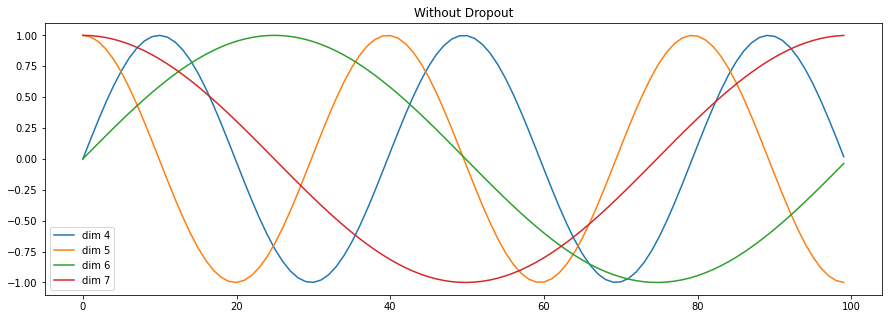

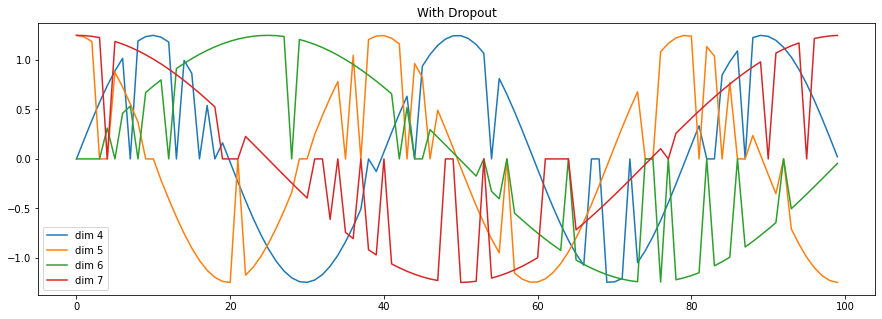

In [28]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)
    

plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in range(4, 8)])
plt.title('Without Dropout')

plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0.2)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in range(4, 8)])
plt.title('With Dropout')

## Full Model

In [29]:
def make_model(src_vocab, tgt_vocab,
               N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

## More PyTorch Example

- https://pytorch.org/tutorials/beginner/transformer_tutorial.html